# Детекция выбросов и аномалий

In [1]:
import pandas as pd
from scipy import stats, interpolate
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import eif as iso

import matplotlib.pyplot as plt
import plotly.express as px

import ipywidgets as widgets
from ipywidgets import interact, interact_manual


# Детекция выбросов и аномалий для Series

Допустим, нам необходимо оценить среднее время протекание какого-то процесса. У нас есть время (в секундах) по каждому экземпляру этого процесса за рассматриваемый период (допустим за месяц).

In [2]:
data = pd.read_csv('сканы.csv', index_col=[0])
data.head()

C:\Users\Baturin.GG\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,дата начала скана,продолжительность
0,2021-05-31 17:20:09,1
1,2021-05-31 17:20:09,18
2,2021-05-29 11:25:12,1
3,2021-05-29 11:25:12,4
4,2021-05-29 18:47:23,1


Мы точно знаем, что в данных нет пропусков, что все данные имеют нормальный тип, поэтому не будем тратить время на предобработку. 

Сразу заведем табличку, в которую будем вписывать результаты:

In [3]:
results_series = pd.DataFrame(columns=['способ','средняя продолжительность','медиана продолжительности','использовано данных'])




results_series = results_series.append(
                    {
                    'способ':'исходные данные',
                    'средняя продолжительность' : data['продолжительность'].mean(),
                    'медиана продолжительности' : data['продолжительность'].median(),
                     'использовано данных':"{:,.2f}%".format(data.shape[0]/data.shape[0]*100)
                    
                    } , 
                    ignore_index=True)

results_series

,способ,средняя продолжительность,медиана продолжительности,использовано данных
0,исходные данные,5.753645,2.0,100.00%


## Интерквартильный интервал

Простой и действенный метод. Заключается в том, что мы находим длинну второго квартиля и откладываем по полтора этого расстояния вниз от верхней границы первого квартиля и вверх от верхней границы третьего квартиля. Все что не входит в полученный отрезок - выбросы.


In [4]:
iqr = (data.describe().T['75%'].values[0] - data.describe().T['25%'].values[0])

low = data.describe().T['25%'].values[0] - 1.5*iqr
high = data.describe().T['75%'].values[0]+1.5*iqr


results_series = results_series.append(
                    {
                    'способ':'интерквартильный интервал',
                    'средняя продолжительность' : data[(data['продолжительность']<=high) & (data['продолжительность']>=low)]['продолжительность'].mean(),
                    'медиана продолжительности' : data[(data['продолжительность']<=high) & (data['продолжительность']>=low)]['продолжительность'].median(),
                     'использовано данных':"{:,.2f}%".format(data[(data['продолжительность']<=high) & (data['продолжительность']>=low)]['продолжительность'].shape[0]/data.shape[0]*100)
                    
                    } , 
                    ignore_index=True)

results_series

,способ,средняя продолжительность,медиана продолжительности,использовано данных
0,исходные данные,5.753645,2.0,100.00%
1,интерквартильный интервал,2.346308,2.0,90.79%


## Z-оценка
или стандартизированная оценка -  мера относительного разброса наблюдаемого или измеренного значения, которая показывает, сколько стандартных отклонений составляет его разброс относительного среднего значения. Это безразмерный статистический показатель, используемый для сравнения значений разной размерности или шкалой измерений.

Поиск выбросов этим методом заключается в нахождении распределения данных, где среднее значение равно 0, а стандартное отклонение равно 1. Все точки, которые слишком далеки от нуля - выбросы. В большенстве случаев в качестве порогового значения используются значения в -3 и 3, а все значения, для которых z-оценка не попадает в этот интервал - размечаются как выбросы.

In [5]:
z = np.abs(stats.zscore(data['продолжительность']))
data['z-score'] = z

results_series = results_series.append(
                    {
                    'способ':'z-оценка',
                    'средняя продолжительность' : data.query('-3<`z-score`<3')['продолжительность'].mean(),
                    'медиана продолжительности' : data.query('-3<`z-score`<3')['продолжительность'].median(),
                     'использовано данных':"{:,.2f}%".format(data.query('-3<`z-score`<3')['продолжительность'].shape[0]/data.shape[0]*100)
                    
                    } , 
                    ignore_index=True)

results_series

,способ,средняя продолжительность,медиана продолжительности,использовано данных
0,исходные данные,5.753645,2.0,100.00%
1,интерквартильный интервал,2.346308,2.0,90.79%
2,z-оценка,3.601621,2.0,99.92%


## Авторски метод

Предлагаемая идея не нова и является вариацией метода локтя. Мы считаем количество экземпляров операций, которые производятся за определенный интервал времени (например от 0 до 10 секунд, от 0 до 20 секунд, от 0 до 30 секунд и тд), наносим эти точки на график "Интервал времени / Количество операций", и смотрим, где у нас кривая перестает активно расти и уходит в боковик, т.е. интервал растет, а вот количество перестает сильно меняться. Найдя точку, начиная с которой график уходит в боковик - найдем ту самую верхнюю границу времени, до которой можно считать, что время на 1 экземпляр операции находится в пределах нормы.

,от 0 до 0 сек.,от 0 до 10 сек.,от 0 до 20 сек.,от 0 до 30 сек.,от 0 до 40 сек.,от 0 до 50 сек.,от 0 до 60 сек.,от 0 до 90 сек.,от 0 до 120 сек.,от 0 до 150 сек.,от 0 до 180 сек.,от 0 до 210 сек.,от 0 до 240 сек.,от 0 до 270 сек.,от 0 до 300 сек.,от 0 до 360 сек.,от 0 до 420 сек.,от 0 до 480 сек.,от 0 до 540 сек.,от 0 до 600 сек.
кол-во,64,13872920,14264566,14357939,14395484,14414128,14424248,14435377,14441319,14445050,14447842,14449900,14451382,14452637,14453711,14455374,14456658,14457662,14458503,14459156


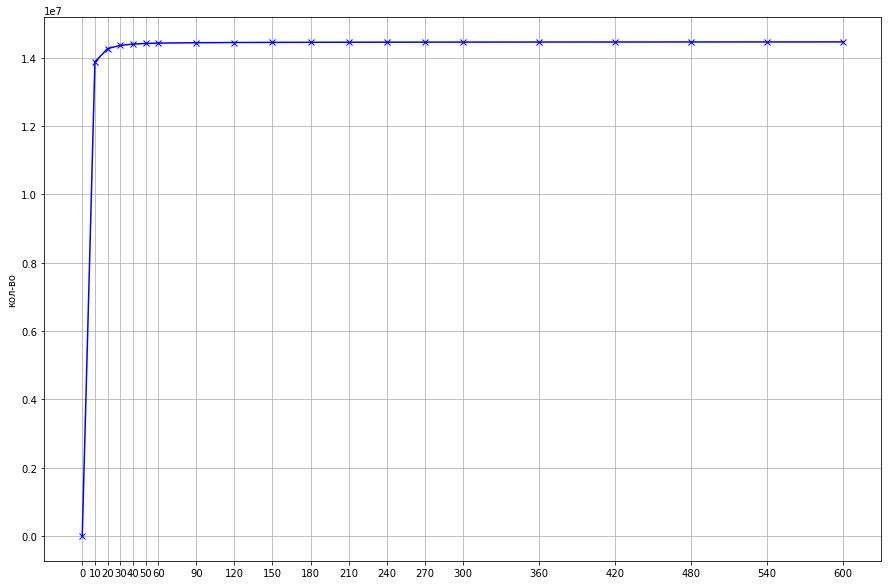

In [6]:


# напишем функцию, которая считает количество
def quantity(temp_df, col, param):
    # проверим, что датафрейм не пуст, если пуст - будем возвращать 0
    if temp_df[(temp_df[col]<=param)&(temp_df[col]>=0)].shape[0]>0:
        value = temp_df[(temp_df[col]<=param)&(temp_df[col]>=0)][col].count()
    else: 
        value = 0
    return value


# напишем функцию которая перебирает все границы и считает для них количество
def quantity_per_bound(temp_df, column, list_of_bounds):    
    temp_arr=[]
    names=[] 
    col = column
    for el in list_of_bounds:
        temp_arr.append(quantity(temp_df, col, el))
        names.append("от 0 до "+str(el)+" сек.")
   
    plotting_df = pd.DataFrame([temp_arr], columns=names).rename({0:'кол-во'}, axis='index')
    display (plotting_df)
    
    x = list_of_bounds
    y = plotting_df.iloc[0,0:].values
    
    plt.figure(figsize=(15,10))
    plt.plot(x, y,'-bx')
    plt.ylabel('кол-во')
    plt.xticks(list_of_bounds)
    plt.grid(True)
    plt.show()
    return plotting_df

params = [0, 10,20, 30, 40, 50, 60, 90, 120, 150, 180, 210, 240, 270, 300, 360, 420, 480, 540,600]
column = 'продолжительность'
t = quantity_per_bound(data, column, params)

Поскольку у нас кусочно-линейная функция, то можем использовать сплайн-интерполяцию, чтобы определить точку поворота графика. В этой точке 2 производная будет самой высокой и будет менять знак, а раз функция у нас возрастающая, то знак она будет менять с минуса на плюс. Однако, поскольку нас интересует последняя точка поворота, то, мы будем брать индекс последнего положительного элемента в списке вторых производных (в этом случае 2 производная может быть не максимальной).

In [7]:


# верхние границы наших интервалов.
# интервалы выглядят так: от 0 до 0, от 0 до 10, от 0 до 20 и тд.
x = params

# количество сканов в интервале
# в интервале от 0 до 0 - 64 скана, от 0 до 10 - 13 872 920  и тд.
y = t.values[0]

# найдем значение 2 производной в точках

dev_2 = interpolate.splev(x, interpolate.splrep(x, y, k=2, s=0), der=2)

# найдем индексы положительных элементов 2 производной
index = [i for i, x in enumerate(dev_2) if x > 0]

# посмотрим, при каком значении х осуществяется последний поворот
print(f'следует брать интервал от 0 до {x[index[-1]]} секунд')


следует брать интервал от 0 до 40 секунд


In [8]:
upper_bound = x[index[-1]]

results_series = results_series.append(
                    {
                    'способ':'авторский метод',
                    'средняя продолжительность' : data.query('`продолжительность`<@upper_bound')['продолжительность'].mean(),
                    'медиана продолжительности' : data.query('`продолжительность`<@upper_bound')['продолжительность'].median(),
                     'использовано данных':"{:,.2f}%".format(data.query('`продолжительность`<@upper_bound').shape[0]/data.shape[0]*100)
                    
                    } , 
                    ignore_index=True)

results_series

,способ,средняя продолжительность,медиана продолжительности,использовано данных
0,исходные данные,5.753645,2.0,100.00%
1,интерквартильный интервал,2.346308,2.0,90.79%
2,z-оценка,3.601621,2.0,99.92%
3,авторский метод,3.178898,2.0,99.48%


# Детекция выбросов и аномалий для DataFrame

А что если у нас не Series, а Dataframe? Как нам тогда проводить чистку?

In [9]:
data = pd.read_csv('data.csv', delimiter=';')
data.head()

,кол-во,время
0,265,1070.397906
1,793,265.955460
2,204,699.758065
3,413,856.794212
4,803,514.085756


Создадим сразу датафрейм и будем записывать туда результаты

In [10]:
results_dataframe = pd.DataFrame(columns=['способ','ср.время','медиана ср. времени', 'ср.количество','медиана кол-во','использовано данных'])

results_dataframe = results_dataframe.append(
                    {
                    'способ':'исходные данные',
                    'ср.время' : data['время'].mean(),
                    'медиана ср. времени' : data['время'].median(),
                     'ср.количество':data['кол-во'].mean(),
                     'медиана кол-во':data['кол-во'].median(),
                     'использовано данных':"{:,.2f}%".format(data.shape[0]/data.shape[0]*100)
                    
                    } , 
                    ignore_index=True)
results_dataframe

,способ,ср.время,медиана ср. времени,ср.количество,медиана кол-во,использовано данных
0,исходные данные,689.513728,642.700881,641.743538,418.0,100.00%


## Изолирующий лес

Этот алгоритм изолирует аномалии за счет того, что случайным образом выбирает объект из заданного набора объектов, а затем случайным образом выбирает значение разделения между максимальным и минимальным значениями выбранного объекта. Это случайное разбиение объектов приводит к созданию меньших путей в деревьях для аномальных значений данных и отличает их от нормального набора данных. Затем, каждое дерево в лесе передает информацию о каждой точке, считает ли оно эту точку выбросом или нет. На основе простого прямого голосования изолирующий лес принимает решение, является ли точка выбросом или нет.  Про алгоритм изолирующего дерева, изолирующего леса и расширенного изолирующего леса доступно объясняют вот тут:https://www.youtube.com/watch?v=cRzeotaFDwk


Разметим наш датафрейм на аномалии и нет. -1 будет говорить, что точка размечена как аномалия, 1- что не аномалия.

In [11]:

quantity = 'кол-во'
time = 'время'

isolation_forest_df = data.reset_index().drop(columns='index').copy()

# обучим стандартизацию
scaler = StandardScaler()
scaler.fit(isolation_forest_df)

# и стандартизируем эту копию, чтоб дальше работать уже с ней
data_scaler = scaler.transform(isolation_forest_df)

# разметим на выбросы и не выбросы
marks = IsolationForest(max_samples = data_scaler.shape[0], 
                        contamination = 'auto', 
                        random_state=12345).fit_predict(data_scaler)


# добавим пометку
isolation_forest_df = isolation_forest_df.assign(метка = marks)

isolation_forest_df

,кол-во,время,метка
0,265,1070.397906,1
1,793,265.955460,1
2,204,699.758065,1
3,413,856.794212,1
4,803,514.085756,1
...,...,...,...
1968,449,439.526462,1
1969,598,343.372137,1
1970,175,1061.473214,1
1971,153,972.866667,1


In [12]:
results_dataframe = results_dataframe.append(
                    {
                    'способ':'классический изоляционный лес',
                    'ср.время' : isolation_forest_df.query('`метка`!=-1')['время'].mean(),
                    'медиана ср. времени' : isolation_forest_df.query('`метка`!=-1')['время'].median(),
                     'ср.количество':isolation_forest_df.query('`метка`!=-1')['кол-во'].mean(),
                     'медиана кол-во':isolation_forest_df.query('`метка`!=-1')['кол-во'].median(),
                     'использовано данных':"{:,.2f}%".format(isolation_forest_df.query('`метка`!=-1').shape[0]/data.shape[0]*100)
                    
                    } , 
                    ignore_index=True)
results_dataframe

,способ,ср.время,медиана ср. времени,ср.количество,медиана кол-во,использовано данных
0,исходные данные,689.513728,642.700881,641.743538,418.0,100.00%
1,классический изоляционный лес,664.522707,636.230924,547.816040,399.0,90.37%


## Расширенный изолирующий лес

Данный алгоритм является улучшением изолирующего леса, которое заключается в том, что отсечения в расширенной версии - могут делаться под углом, в то время как в классической - либо строго вертикально, либо строго горизонтально.

В sklearn нет метода, который реализовывал бы этот алгоритм, поэтому воспользуемся сторонней библиотекой eif. 

N.b.: для классической вариации изолирующего леса тоже можно использовать эту библиотеку, только необходимо передать 0 в качестве значения параметра ExtensionLevel

In [13]:
extended_isolation_forest_df = data.reset_index().drop(columns='index').copy()


X = data_scaler

F1  = iso.iForest(X, ntrees=200, sample_size=len(X), ExtensionLevel=1)

# задетектим аномалии по оценке и если оценка больше 0.5 - будем считать аномалией

anomality = []
for el in F1.compute_paths(X_in = X):
    if el >=0.5:
        anomality.append(-1)
    else:
        anomality.append(1)


# добавим метку аномальности
extended_isolation_forest_df = extended_isolation_forest_df.assign(метка = anomality)

extended_isolation_forest_df 


,кол-во,время,метка
0,265,1070.397906,1
1,793,265.955460,1
2,204,699.758065,1
3,413,856.794212,1
4,803,514.085756,1
...,...,...,...
1968,449,439.526462,1
1969,598,343.372137,1
1970,175,1061.473214,1
1971,153,972.866667,1


In [14]:
results_dataframe = results_dataframe.append(
                    {
                    'способ':'расширенный изоляционный лес',
                    'ср.время' : extended_isolation_forest_df.query('`метка`!=-1')['время'].mean(),
                    'медиана ср. времени' : extended_isolation_forest_df.query('`метка`!=-1')['время'].median(),
                     'ср.количество':extended_isolation_forest_df.query('`метка`!=-1')['кол-во'].mean(),
                     'медиана кол-во':extended_isolation_forest_df.query('`метка`!=-1')['кол-во'].median(),
                     'использовано данных':"{:,.2f}%".format(extended_isolation_forest_df.query('`метка`!=-1').shape[0]/data.shape[0]*100)
                    
                    } , 
                    ignore_index=True)
results_dataframe

,способ,ср.время,медиана ср. времени,ср.количество,медиана кол-во,использовано данных
0,исходные данные,689.513728,642.700881,641.743538,418.0,100.00%
1,классический изоляционный лес,664.522707,636.230924,547.816040,399.0,90.37%
2,расширенный изоляционный лес,666.801513,636.230924,551.665945,399.0,93.61%


Сделаем визуальное сравнение

In [15]:
compare = extended_isolation_forest_df.join( isolation_forest_df['метка'], 
                                    how='left', 
                                    lsuffix='_расширенный изолирующий лес',  
                                    rsuffix='_классический изолирующий лес')

@interact
def scatter_plot(x = list(compare.select_dtypes('number').columns)[0], 
                 y = list(compare.select_dtypes('number').columns)[1],
                 z = list(compare.select_dtypes('number').columns)[2:]):
    
    # сделаем цвета дискретными
    fig = px.scatter(compare, 
                    x = x, 
                    y = y, 
                    hover_name = compare.columns[0], 
                    color = z, 
                    opacity = 1,
                    width = 1000, 
                    height = 700,
                    labels = { # replaces default labels by column name
                                "x": 'количество',  
                                "y": 'время'
                            }
                    ) 

    fig.update_layout(
        xaxis_title = x,
        yaxis_title = y)
    fig.show()

interactive(children=(Text(value='кол-во', description='x'), Text(value='время', description='y'), Dropdown(de…

## Авторское дополнение расширенного изолирующего леса

Как видим, не что не идеально, даже расширенное изолирующие дерево, благодоря случайности разбиения, может содержать в области "не аномалий" точки, которые размечены как аномалия. <img src="pic/Безымянный.png">
 Исправим это


In [16]:
# для начала определим область "НЕ аномалий"
x_1 = extended_isolation_forest_df.query('`метка`==1')[quantity].min()
x_2 = extended_isolation_forest_df.query('`метка`==1')[quantity].max()

y_1 = extended_isolation_forest_df.query('`метка`==1')[time].min()
y_2 = extended_isolation_forest_df.query('`метка`==1')[time].max()


# теперь, для всех точек, которые входят в область - поставим метко не аномальности


new_extended_isolation_forest_df = extended_isolation_forest_df.copy()
new_extended_isolation_forest_df.loc[
                                (new_extended_isolation_forest_df['кол-во']>=x_1)& \
                                (new_extended_isolation_forest_df['кол-во']<=x_2)& \
                                (new_extended_isolation_forest_df['время']>=y_1)& \
                                (new_extended_isolation_forest_df['время']<=y_2),
                                'метка'] = 1


И посмотрим результаты

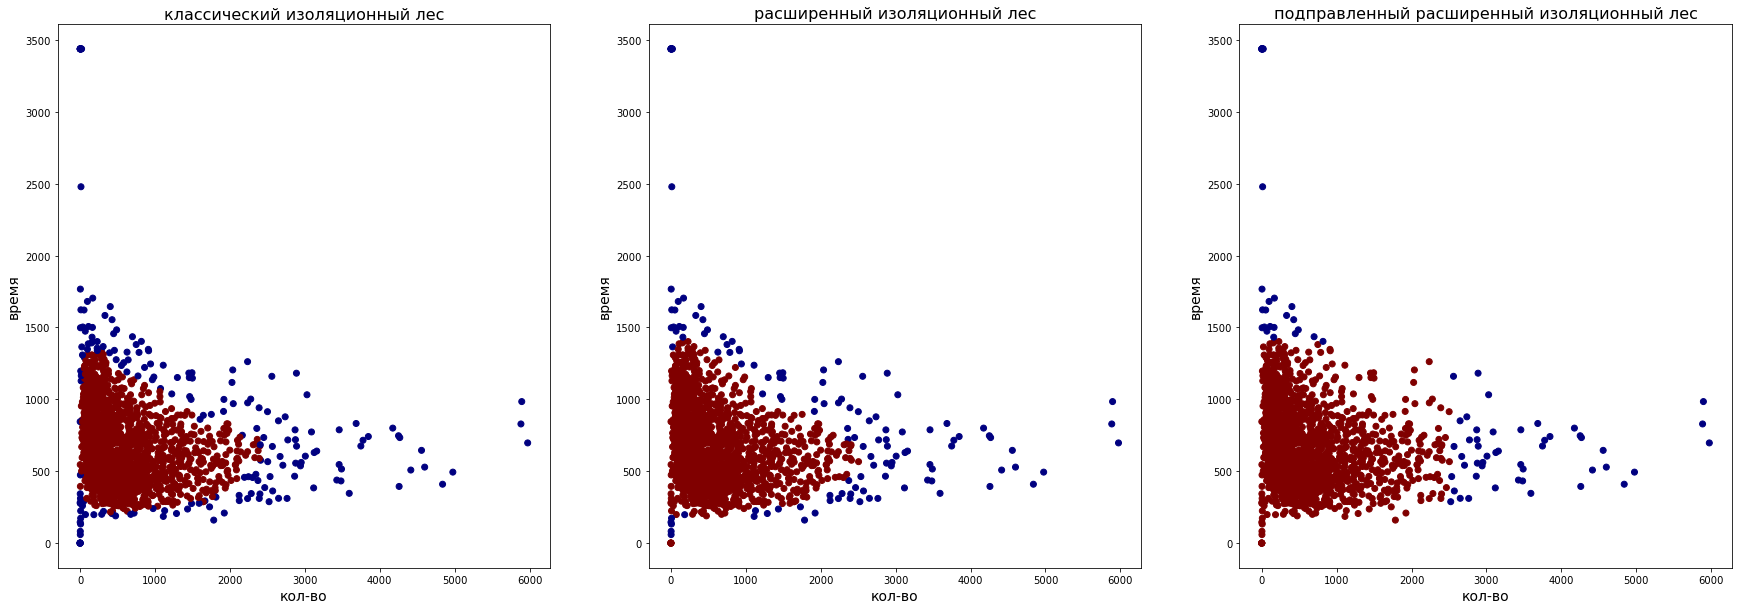

In [17]:
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=False)
fig.set_figheight(10)
fig.set_figwidth(30)


ax[0].scatter(isolation_forest_df.values[:,0], isolation_forest_df.values[:,1],  c=vectorizer(isolation_forest_df['метка'].values))
ax[0].set_title('классический изоляционный лес', fontsize=16)
ax[0].set_xlabel ('кол-во', fontsize=14)
ax[0].set_ylabel ('время', fontsize=14)

ax[1].scatter(extended_isolation_forest_df.values[:,0], extended_isolation_forest_df.values[:,1],  c=vectorizer(extended_isolation_forest_df['метка'].values))
ax[1].set_title('расширенный изоляционный лес', fontsize=16)
ax[1].set_xlabel ('кол-во', fontsize=14)
ax[1].set_ylabel ('время', fontsize=14)

ax[2].scatter(new_extended_isolation_forest_df.values[:,0], new_extended_isolation_forest_df.values[:,1],  c=vectorizer(new_extended_isolation_forest_df['метка'].values))
ax[2].set_title('подправленный расширенный изоляционный лес', fontsize=16)
ax[2].set_xlabel ('кол-во', fontsize=14)
ax[2].set_ylabel ('время', fontsize=14)

plt.show()

In [18]:
results_dataframe = results_dataframe.append(
                    {
                    'способ':'подправленный изоляционный лес',
                    'ср.время' : new_extended_isolation_forest_df.query('`метка`!=-1')['время'].mean(),
                    'медиана ср. времени' : new_extended_isolation_forest_df.query('`метка`!=-1')['время'].median(),
                     'ср.количество':new_extended_isolation_forest_df.query('`метка`!=-1')['кол-во'].mean(),
                     'медиана кол-во':new_extended_isolation_forest_df.query('`метка`!=-1')['кол-во'].median(),
                     'использовано данных':"{:,.2f}%".format(new_extended_isolation_forest_df.query('`метка`!=-1').shape[0]/data.shape[0]*100)
                    
                    } , 
                    ignore_index=True)
results_dataframe

,способ,ср.время,медиана ср. времени,ср.количество,медиана кол-во,использовано данных
0,исходные данные,689.513728,642.700881,641.743538,418.0,100.00%
1,классический изоляционный лес,664.522707,636.230924,547.816040,399.0,90.37%
2,расширенный изоляционный лес,666.801513,636.230924,551.665945,399.0,93.61%
3,подправленный изоляционный лес,668.743475,636.916667,576.770163,410.0,96.15%
